# Color Discretization

### ColorDiscretizer demo

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append("../")

In [3]:
from utils.color_discretizer import ColorDiscretizer
from utils.color_utils import YUV_to_RGB, RGB_to_YUV
import numpy as np
import matplotlib.pyplot as plt
from keras.utils import to_categorical

%matplotlib inline

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [4]:
cd = ColorDiscretizer(max_categories=32)
imdir = "../data/iccv09Data/images/"
cd.train(imdir, 30)

../utils/color_discretizer.py:86: RuntimeWarning: divide by zero encountered in log10
  logheatmap = np.log10(hm)


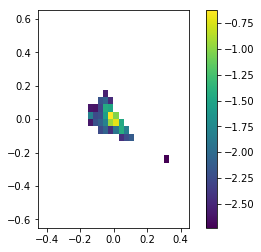

In [5]:
cd.plot_heatmap()

In [6]:
from matplotlib.pyplot import imread
from utils.color_utils import RGB_to_YUV

image = imread("../data/iccv09Data/images/0000051.jpg").astype(np.dtype("float32"))
YUVimage = RGB_to_YUV(image)
UVimage = YUVimage[:, :, 1:]
UVpixels = np.reshape(UVimage, newshape=[-1, 2])

In [7]:
cd.categorize(UVimage)

array([[30, 30, 30, ..., 30, 30, 30],
       [30, 30, 30, ..., 30, 30, 30],
       [30, 30, 30, ..., 30, 30, 30],
       ...,
       [13, 13, 13, ..., 19, 19, 19],
       [13, 13, 13, ..., 19, 19, 19],
       [13, 13, 13, ..., 19, 19, 19]])

In [8]:
for i in range(cd.max_categories):
    print(i, 
          cd.indices_to_xycategories_map[i], 
          '\t', 
          cd.categories_mean_pixels[i],
          '\t',
          cd.category_frequency[i],
          '\t',
          cd.weights[i],
         )

0 (10, 14) 	 [0. 0.] 	 0.0029305437703295158 	 4.916504046971231
1 (10, 15) 	 [-0.135       0.02166667] 	 0.015950272238721537 	 2.2227296395807987
2 (10, 16) 	 [-0.135  0.065] 	 0.007006169565832272 	 3.5643023106067666
3 (11, 14) 	 [-0.105      -0.02166667] 	 0.006757353981049356 	 3.6251714150542256
4 (11, 15) 	 [-0.105       0.02166667] 	 0.005647185688021496 	 3.924179167171781
5 (11, 16) 	 [-0.105  0.065] 	 0.0037203012303775986 	 4.579825587775677
6 (12, 13) 	 [-0.075 -0.065] 	 0.005677238014425117 	 3.915436913388051
7 (12, 14) 	 [-0.075      -0.02166667] 	 0.008592313675576297 	 3.2196780297633367
8 (12, 15) 	 [-0.075       0.02166667] 	 0.006177962805826616 	 3.7753017113641807
9 (12, 16) 	 [-0.075  0.065] 	 0.005150880356385236 	 4.074417067273508
10 (12, 17) 	 [-0.075       0.10833333] 	 0.009861140574176211 	 2.9885307416961573
11 (13, 13) 	 [-0.045 -0.065] 	 0.008762904822514496 	 3.18654167057632
12 (13, 14) 	 [-0.045      -0.02166667] 	 0.015722228114835243 	 2.24426719

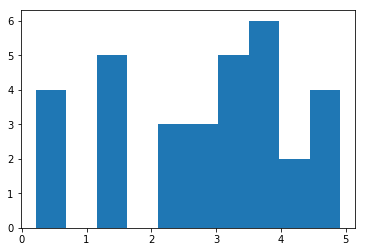

In [12]:
plt.hist(list(cd.weights.values()))
plt.show()

In [13]:
categories_distributions = np.abs(np.random.rand(4, 4, cd.n_categories))
cd.UVpixels_from_distribution(categories_distributions)

array([[[-0.01564371, -0.01045014],
        [-0.03044566,  0.00809957],
        [-0.01097132, -0.00150361],
        [-0.01593007, -0.00190308]],

       [[-0.01647092, -0.00267432],
        [-0.01455999, -0.00812983],
        [-0.01082196, -0.01063002],
        [-0.01528383, -0.00254272]],

       [[-0.02489178, -0.00907012],
        [-0.00897292, -0.02003884],
        [-0.02684675,  0.00897972],
        [-0.01202797, -0.00225171]],

       [[-0.01562396, -0.00531436],
        [-0.01418341, -0.00964305],
        [-0.02270289, -0.00320168],
        [-0.00622856, -0.00767697]]])

### L2 cost of categorizing

In [14]:
image = imread("../data/iccv09Data/images/0002136.jpg").astype(np.dtype("float32"))
YUVimage = RGB_to_YUV(image)
UVimage = YUVimage[:, :, 1:]
Yimage = YUVimage[:, :, :1]

In [15]:
pixels_categories = cd.categorize(UVimage)

pixel_categories_onehot = to_categorical(pixels_categories, num_classes=cd.n_categories)

reconstructed_UVimage = cd.UVpixels_from_distribution(pixel_categories_onehot)

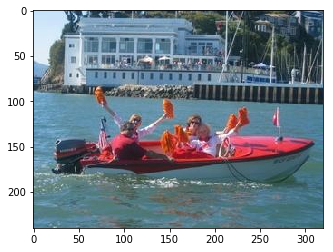

In [16]:
plt.imshow(YUV_to_RGB(np.concatenate([Yimage, UVimage], axis=2))/255.)
plt.show()

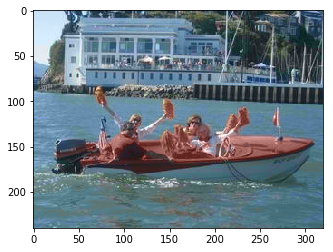

In [17]:
plt.imshow(YUV_to_RGB(np.concatenate([Yimage, reconstructed_UVimage], axis=2)) / 255)
plt.show()

In [18]:
np.linalg.norm(reconstructed_UVimage - UVimage, axis = (0, 1)) / len(UVpixels) / np.std(UVpixels, axis = 0)

array([0.00111378, 0.00307411])

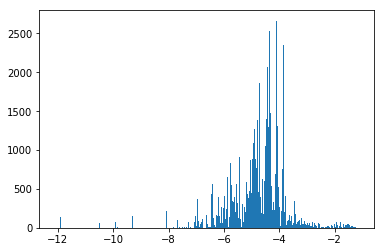

In [19]:
plt.hist(np.reshape(np.log(np.abs(reconstructed_UVimage - UVimage)), [-1, 1]), bins = 1000)
plt.show()

Note that sometimes, the return to RGB space goes over 255 or below 0, so we added a correction to the function.

In [20]:
print(np.max(YUV_to_RGB(np.concatenate([Yimage, UVimage], axis=2),correction = False)))
print(np.min(YUV_to_RGB(np.concatenate([Yimage, UVimage], axis=2),correction = False)))

255.00000000000006
-2.1282261841509484e-14


In [21]:
print(np.max(YUV_to_RGB(np.concatenate([Yimage, reconstructed_UVimage], axis=2), correction = False)))
print(np.min(YUV_to_RGB(np.concatenate([Yimage, reconstructed_UVimage], axis=2), correction = False)))

262.7552789347832
-0.8897994003679006


### Thresholding out rare pixels

../utils/color_discretizer.py:87: RuntimeWarning: divide by zero encountered in log10
  extent = [self.xedges[0], self.xedges[-1], self.yedges[0], self.yedges[-1]]


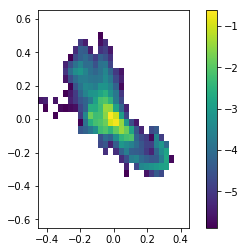

Remaining colors: 208


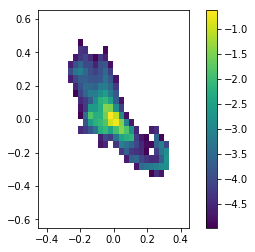

Remaining colors: 162


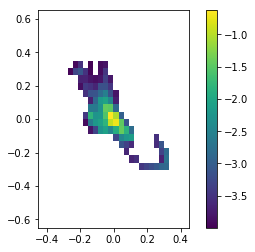

Remaining colors: 94


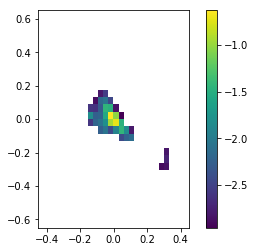

Remaining colors: 40


In [24]:
for threshold in [.000001, .00001, .0001, .001]:
    cd = ColorDiscretizer(threshold=threshold)
    imdir = "../data/iccv09Data/images/"
    cd.train(imdir, 30)
    cd.plot_heatmap()
    print("Remaining colors: {}".format(np.sum(cd.heatmap > cd.threshold)))

### Using a fixed number of categories

../utils/color_discretizer.py:87: RuntimeWarning: divide by zero encountered in log10
  extent = [self.xedges[0], self.xedges[-1], self.yedges[0], self.yedges[-1]]


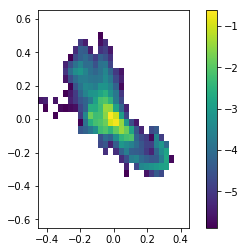

Remaining colors: 208


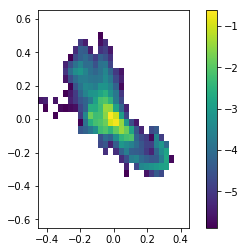

Remaining colors: 199


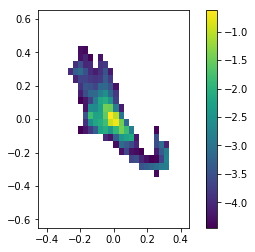

Remaining colors: 125


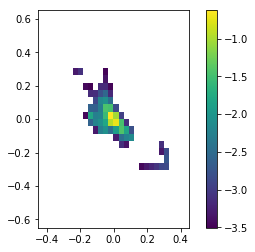

Remaining colors: 64


In [25]:
for max_cat in [250,200,128,64]:
    cd = ColorDiscretizer(threshold=.000001,max_categories=max_cat)
    imdir = "../data/iccv09Data/images/"
    cd.train(imdir, 30)
    cd.plot_heatmap()
    print("Remaining colors: {}".format(np.sum(cd.heatmap > cd.threshold)))